In [2]:
import pandas as pd

data = pd.read_csv('../data/non_annualized_OH_max_rounded_yields.csv')
data.head()

,Yield (tons/acre),Total Radiation (W/m^2),Total Rainfall (mm),Avg Min Temp (C),Avg Max Temp (C)
0,2,120668.5,1674.51,6.559924,16.771807
1,2,120668.5,1674.51,6.559924,16.771807
2,3,120668.5,1674.51,6.559924,16.771807
3,3,120668.5,1674.51,6.559924,16.771807
4,2,120668.5,1674.51,6.559924,16.771807


In [3]:
# from sdv.tabular import TVAE

# model = TVAE()
# model.fit(data)

In [4]:
#new_data = model.sample(2000)

In [5]:
#new_data.to_csv('data/VAE_synth2k_0721_KY_WI_rf_dt.csv')
#new_data.head()

In [6]:
# get aggregate data
targetDataLoc = '../data/non_annualized_OH_max_rounded_yields.csv'
#aggDataLoc = 'data/synth1_GA_only_063022.csv'

aggDf = data #pd.read_csv(aggDataLoc)
#aggDf = aggDf.drop("Unnamed: 0",axis=1)
targetDf = pd.read_csv(targetDataLoc)
#targetDf = targetDf.drop("Unnamed: 0",axis=1)

In [7]:
############## imports
# general
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score  
# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVR  # support vector machines regression
from sklearn.svm import SVC  # support vector machines classification
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neighbors import KNeighborsClassifier # k-nearest neightbors for classification
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.neural_network import MLPClassifier # neural network for classification
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # adaboost for classification
import xgboost as xgb
# saving models
# from sklearn.externals import joblib
import joblib

# import the API
APILoc = 'API/'

import sys
sys.path.insert(0, APILoc)

from API import *

In [8]:
# filter out the features that will not be used by the machine learning models

# the features to keep:
# xColumnsToKeep = ["Julian Day", "Time Since Sown (Days)", "Time Since Last Harvest (Days)", "Total Radiation (MJ/m^2)",
#                "Total Rainfall (mm)", "Avg Air Temp (C)", "Avg Min Temp (C)", "Avg Max Temp (C)",
#                  "Avg Soil Moisture (%)", "Day Length (hrs)"], "Percent Cover (%)"]

xColumnsToKeep = ["Total Radiation (W/m^2)","Total Rainfall (mm)", "Avg Max Temp (C)", "Avg Min Temp (C)"]


#xColumnsToKeep = ["Julian Day", "Time Since Sown (Days)", "Total Radiation (MJ/m^2)", "Total Rainfall (mm)"]

# the target to keep
yColumnsToKeep = ["Yield (tons/acre)"]

# get a dataframe containing the features and the targets
xDf = aggDf[xColumnsToKeep]
test_xDf = targetDf[xColumnsToKeep]
yDf = aggDf[yColumnsToKeep]
test_yDf = targetDf[yColumnsToKeep]

# reset the index
xDf = xDf.reset_index(drop=True)
yDf = yDf.reset_index(drop=True)
test_xDf = test_xDf.reset_index(drop=True)
test_yDf = test_yDf.reset_index(drop=True)

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)

xCols = list(xDf)

In [9]:
# hide the warnings because training the neural network caues lots of warnings.
import warnings
warnings.filterwarnings('ignore')

# make the parameter grids for sklearn's gridsearchcv
rfParamGrid = {
        'model__n_estimators': [5, 10, 25, 50, 100], # Number of estimators
        'model__max_depth': [5, 10, 15, 20], # Maximum depth of the tree
        'model__criterion': ["gini"]
    }
knnParamGrid ={
        'model__n_neighbors':[2,5,10],
        'model__weights': ['uniform', 'distance'],
        'model__leaf_size': [5, 10, 30, 50]    
    }
svrParamGrid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 1.0, 5.0, 10.0],
        'model__gamma': ["scale", "auto"],
        'model__degree': [2,3,4,5]
    }
nnParamGrid = {
        'model__hidden_layer_sizes':[(3), (5), (10), (3,3), (5,5), (7,7)],
        'model__solver': ['sgd', 'adam'],
        'model__learning_rate' : ['constant', 'invscaling', 'adaptive'],
        'model__learning_rate_init': [0.1, 0.01, 0.001]      
    }

linRegParamGrid = {}

bayesParamGrid={
        'model__n_iter':[100,300,500]
    }

dtParamGrid = {
    'model__criterion': ['gini'],
    'model__max_depth': [5,10,25,50,100]
    }

aModelList = [#(RandomForestClassifier(), rfParamGrid, "rfTup.pkl"),
              (KNeighborsClassifier(), knnParamGrid, "knnTup.pkl"),
              (SVC(), svrParamGrid, "svrTup.pkl"),
             #(MLPClassifier(), nnParamGrid, "nnTup.pkl")]#,
             (LogisticRegression(), linRegParamGrid, "logRegTup.pkl")]#,
             #(BayesianRidge(), bayesParamGrid, "bayesTup.pkl"),
             #(DecisionTreeClassifier(), dtParamGrid, "dtTup.pkl")]
             #(xgb.XGBClassifier(), xgbParamGrid, "xgbTup.pkl")]

N = 10
workingDir = 'working_dir'
numFeatures = 4 # 11

model:  knnTup
Avg MAE:  209.79
Avg R squared:  0.793
Best MAE:  111.888
Best R squared:  0.888
Parameters of the best model:  {'model__leaf_size': 5, 'model__n_neighbors': 10, 'model__weights': 'distance'}
Features selected by best model:  ['Total Radiation (W/m^2)', 'Total Rainfall (mm)', 'Avg Max Temp (C)', 'Avg Min Temp (C)']
Accuracy:  0.8531468531468531
f1 score:  0.7842064477578496
mcc:  0.7561977245468852
 
test results on our test data: 


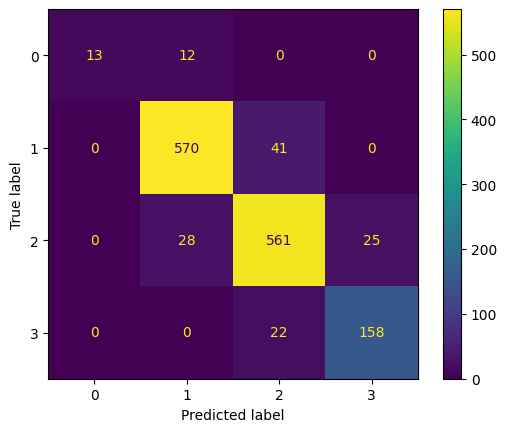

results:
MAE:  0.08951048951048951
R sq:  0.8244673556655405
accuracy score for DA/TDA:  0.9104895104895104
model:  svrTup
Avg MAE:  460.14
Avg R squared:  0.502
Best MAE:  377.622
Best R squared:  0.65
Parameters of the best model:  {'model__C': 10.0, 'model__degree': 2, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Features selected by best model:  ['Total Radiation (W/m^2)', 'Total Rainfall (mm)', 'Avg Max Temp (C)', 'Avg Min Temp (C)']
Accuracy:  0.7342657342657343
f1 score:  0.7190709426349029
mcc:  0.5784974412857643
 
test results on our test data: 


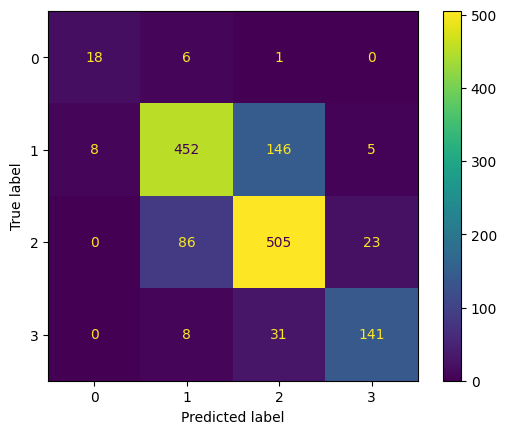

results:
MAE:  0.22937062937062938
R sq:  0.5117998329447846
accuracy score for DA/TDA:  0.7804195804195804
model:  logRegTup
Avg MAE:  911.888
Avg R squared:  0.048
Best MAE:  825.175
Best R squared:  0.177
Parameters of the best model:  {}
Features selected by best model:  ['Total Radiation (W/m^2)', 'Total Rainfall (mm)', 'Avg Max Temp (C)', 'Avg Min Temp (C)']
Accuracy:  0.5664335664335665
f1 score:  0.30459267040149396
mcc:  0.2485482194035938
 
test results on our test data: 


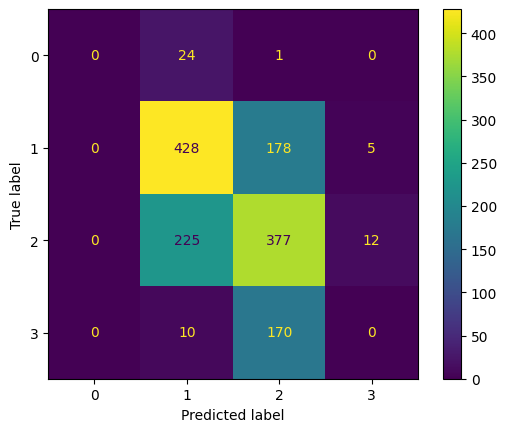

results:
MAE:  0.44825174825174824
R sq:  0.0770822684602247
accuracy score for DA/TDA:  0.5629370629370629


In [11]:
saveMLResults(test_xDf, test_yDf, N, xDf, yDf, aModelList, workingDir, numFeatures, printResults=True)